In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
from shapely.geometry import MultiPoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

sys.path.append("../")

In [3]:
from plot_functions import add_poly
from utils import from_pickle, to_pickle

In [4]:
os.makedirs("outputs/", exist_ok=True)

In [5]:
mpl.rcParams["grid.linestyle"] = ":"
mpl.rcParams["axes.grid"] = True

In [6]:
GEOPHYS_DIR = "D:/03 UofA/02 Code/MPM/QUEST Northwest/Geophys/"
GEOCHEM_DIR = "D:/03 UofA/02 Code/MPM/QUEST Northwest/Geochem/"
GEO_DIR = "D:/03 UofA/02 Code/MPM/QUEST Northwest/BC_digital_geology_shp/"
MIN_DIR = "D:/03 UofA/02 Code/MPM/QUEST Northwest/Minfile/"

In [7]:
geo_channels = from_pickle("./outputs/geo_channels.pkl")
geophys_channels = from_pickle("./outputs/geophys_channels.pkl")
geochem_channels = from_pickle("./outputs/geochem_channels.pkl")

ix_pos, iy_pos = from_pickle("./outputs/postive_locations.pkl")
ix_neg, iy_neg = from_pickle("./outputs/negative_locations.pkl")

rasters = from_pickle("./outputs/geo_rasters.pkl")
_, origin = from_pickle("./outputs/grid_origin.pkl")
keyout = from_pickle("./outputs/keyout.pkl")
alpha_shape = from_pickle("./outputs/boundary_poly.pkl")

# Merge Channels
- Merge various geo channels into a single tensor

In [8]:
for key, value in geo_channels.items():
    print(key + " shape:", value.shape)

topo shape: (3433, 4287, 1)
cover shape: (3433, 4287, 1)
fault shape: (3433, 4287, 1)
class shape: (3433, 4287, 7)


In [9]:
for key, value in geophys_channels.items():
    print(key + " shape:", value.shape)

total_mag shape: (3433, 4287, 1)
vert_deriv shape: (3433, 4287, 1)


In [10]:
for key, value in geochem_channels.items():
    print(key + " shape:", value.shape)

pca shape: (3433, 4287, 33)


In [11]:
channels = [
    *geo_channels.values(),
    *geophys_channels.values(),
    *geochem_channels.values(),
]
tensor = np.concatenate(channels, axis=-1)
n_channels = tensor.shape[-1]
print(tensor.shape)

(3433, 4287, 45)


# Extract Training Examples

In [12]:
def coord_to_2D_idx(x, y, xmin, ymin, xsize, ysize):
    """convert (x, y) to (ix, iy) with top left origin"""
    ix = (np.ceil((x - xmin) / xsize + 0.5) - 1).astype(int)
    iy = (np.ceil((y - ymin) / ysize + 0.5) - 1).astype(int)
    return ix, iy


def idx_2D_to_coord(ix, iy, xmin, ymin, xsize, ysize):
    """convert (ix, iy) to (x, y) with top left origin"""
    x = ix * xsize + xmin
    y = -iy * ysize + ymin
    return x, y


def idx_2D_to_idx_1D(ix, iy, nx, ny):
    """convert (ix, iy) to 1D index with top left origin"""
    return int(ix + iy * nx)


def extract_windows(ix, iy, wx, wy, tensor, nan_value=0.0):
    """get window (wx, wy) surrounding (ix, iy) from tensor"""
    windows = np.zeros((len(ix), wx, wy, tensor.shape[-1]))
    for iloc, (iix, iiy) in enumerate(zip(ix, iy)):
        ix_min = np.int(iix - wx / 2)
        iy_min = np.int(iiy - wy / 2)
        img = tensor[iy_min : iy_min + wy, ix_min : ix_min + wx, :]
        windows[iloc, ...] = np.nan_to_num(img, nan=nan_value)
    return windows

In [13]:
# 1px = 25m
# partion grid into 100x100m or 40x40px windows
grid_nx = geo_channels["topo"].shape[1]
grid_ny = geo_channels["topo"].shape[0]

wx = 100  # 40
wy = 100  # 40
nx = int(grid_nx / wx)
ny = int(grid_ny / wy)
x0 = 0 + wx / 2
y0 = 0 + wy / 2
nxy = nx * ny

X, Y = np.meshgrid(
    np.linspace(x0, x0 + (nx - 1) * wx, nx),
    np.linspace(y0, y0 + (ny - 1) * wy, ny),
)

# xcent, ycent, example_code, keyout
P = np.concatenate(
    (
        X.reshape(nxy, 1),
        Y.reshape(nxy, 1),
        np.zeros(nxy).reshape(-1, 1),
        np.zeros(nxy).reshape(-1, 1),
    ),
    axis=1,
).astype(int)

In [14]:
grid_spec = {
    "nx": nx,
    "ny": ny,
    "xsize": wx,
    "ysize": wy,
    "xsize_px": 25,
    "ysize_px": 25,
    "xmin": origin[1][0] + wx / 2,
    "ymin": origin[0][1] - wy / 2,
}
to_pickle("outputs/grid_spec.pkl", grid_spec)

In [15]:
# keyout based on alpha shape
pt_keyout = []
xmin = origin[1][0] + wx / 2
ymin = origin[0][1] - wy / 2
for loc in P[:, 0:2]:
    point = MultiPoint(
        [
            idx_2D_to_coord(
                *loc[:2],
                xmin,
                ymin,
                grid_spec["xsize_px"],
                grid_spec["ysize_px"]
            )
        ]
    )
    check = alpha_shape.contains(point)
    pt_keyout.append(check)
P[:, -1] = pt_keyout

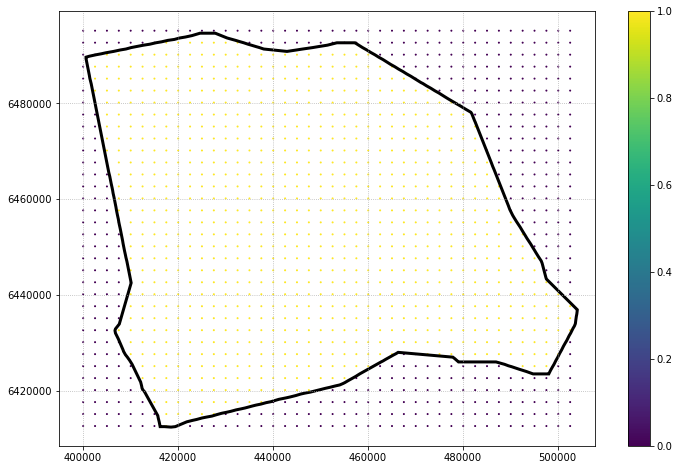

In [16]:
xx, yy = idx_2D_to_coord(P[:, 0], P[:, 1], xmin, ymin, 25, 25)
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.scatter(xx, yy, c=P[:, -1], s=1)
add_poly(ax, alpha_shape, {"fill": False, "lw": 3})
plt.colorbar(im, ax=ax)

In [17]:
# match positive and negative examples to coarser grid centroids
# everything else is undefined
for ix, iy in zip(ix_pos, iy_pos):
    idx = idx_2D_to_idx_1D(*coord_to_2D_idx(ix, iy, 0, 0, wx, wy), nx, ny)
    P[idx][2] = 1

for ix, iy in zip(ix_neg, iy_neg):
    idx = idx_2D_to_idx_1D(*coord_to_2D_idx(ix, iy, 0, 0, wx, wy), nx, ny)
    P[idx][2] = 2

centroids = P[P[:, -1] == 1]

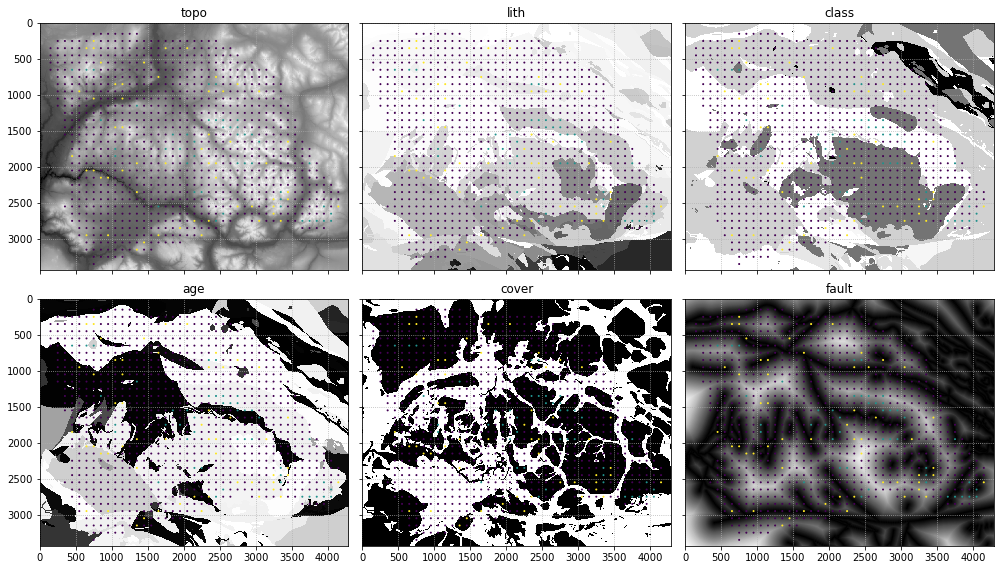

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex="all", sharey="all")
axes = axes.flatten()
for i, (key, var) in enumerate(rasters.items()):
    axes[i].imshow(var[..., 0], cmap="Greys_r")
    axes[i].set_title(key)
    axes[i].scatter(centroids[:, 0], centroids[:, 1], c=centroids[:, 2], s=1)
fig.tight_layout()

In [19]:
to_pickle("./outputs/centroids.pkl", [centroids, P])

## Positive

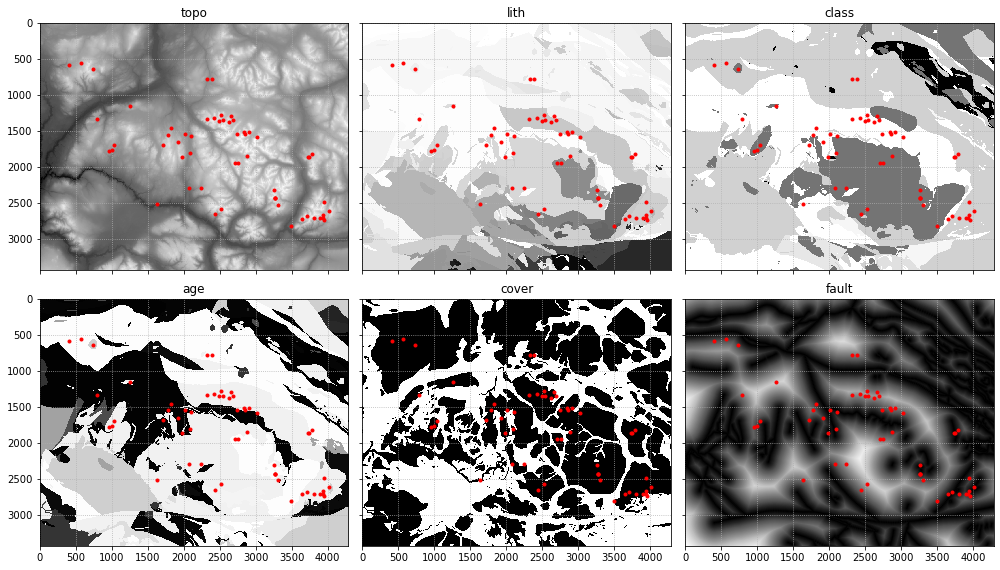

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex="all", sharey="all")
axes = axes.flatten()
for i, (key, var) in enumerate(rasters.items()):
    axes[i].imshow(var[..., 0], cmap="Greys_r")
    axes[i].set_title(key)
    axes[i].plot(ix_pos, iy_pos, c="r", marker=".", ls="None")
fig.tight_layout()

In [21]:
ixp = centroids[centroids[:, 2] == 1][:, 0]
iyp = centroids[centroids[:, 2] == 1][:, 1]
examples_pos = extract_windows(ixp, iyp, wx, wy, tensor)
print(examples_pos.shape)

(46, 100, 100, 45)


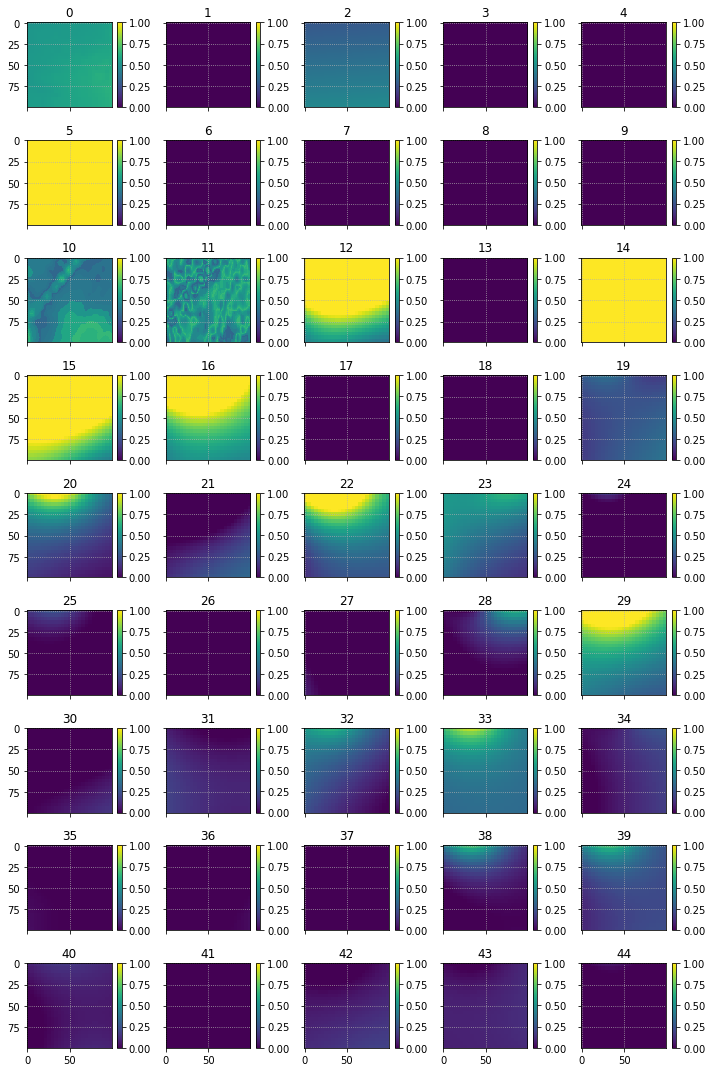

In [56]:
# fig, axes = plt.subplots(12, 10, figsize=(15, 15), sharex="all", sharey="all")
fig, axes = plt.subplots(9, 5, figsize=(10, 15), sharex="all", sharey="all")
axes = axes.flatten()
i = 0
for c, ax in enumerate(axes):
    im = ax.imshow(examples_pos[i, ..., c], vmin=0, vmax=1)
    ax.set_title(c)
    plt.colorbar(im, ax=ax)
fig.tight_layout()

## Negative

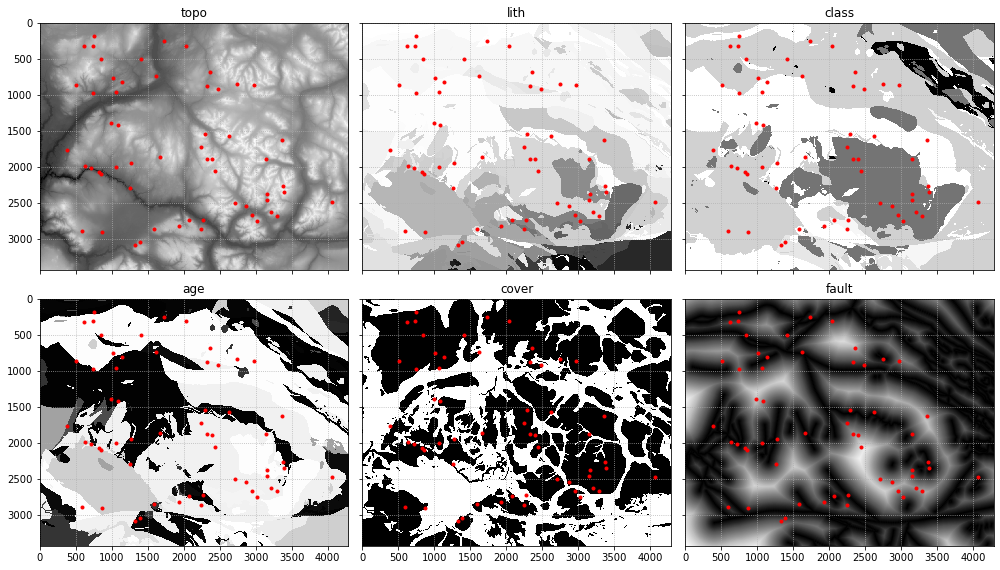

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex="all", sharey="all")
axes = axes.flatten()
for i, (key, var) in enumerate(rasters.items()):
    axes[i].imshow(var[..., 0], cmap="Greys_r")
    axes[i].set_title(key)
    axes[i].plot(ix_neg, iy_neg, c="r", marker=".", ls="None")
fig.tight_layout()

In [25]:
ixn = centroids[centroids[:, 2] == 2][:, 0]
iyn = centroids[centroids[:, 2] == 2][:, 1]
examples_neg = extract_windows(ixn, iyn, wx, wy, tensor)
print(examples_neg.shape)

(56, 100, 100, 45)


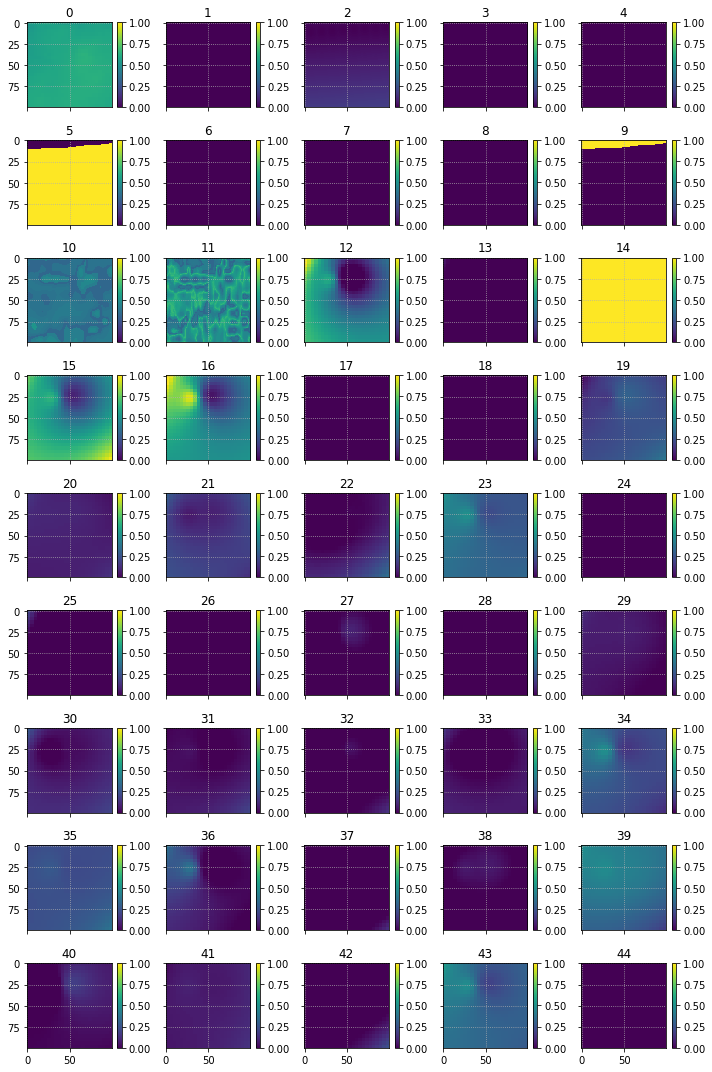

In [27]:
# fig, axes = plt.subplots(12, 10, figsize=(15, 15), sharex="all", sharey="all")
fig, axes = plt.subplots(9, 5, figsize=(10, 15), sharex="all", sharey="all")
axes = axes.flatten()
i = 0
for c, ax in enumerate(axes):
    im = ax.imshow(examples_neg[i, ..., c], vmin=0, vmax=1)
    ax.set_title(c)
    plt.colorbar(im, ax=ax)
fig.tight_layout()

## Prediction

In [28]:
ix_pred = centroids[centroids[:, 2] == 0][:, 0]
iy_pred = centroids[centroids[:, 2] == 0][:, 1]
pred_tensor = extract_windows(ix_pred, iy_pred, wx, wy, tensor)
print(pred_tensor.shape)

(834, 100, 100, 45)


# Image Augmentation

Tensorflow augmentation doesnt work well with multi-channel images so we'll do it manually

In [29]:
def random_crop(tensor, n_crops, px, seed):
    """randomly crop (px, px) tensor n_crops times"""
    rng = np.random.default_rng(217)
    n_samples = tensor.shape[0]
    n_channels = tensor.shape[-1]
    idxs = rng.choice(
        np.arange(grid_spec["xsize"] - px), n_crops, replace=False
    )
    boxes = [(idx, idx, idx + px, idx + px) for idx in idxs]
    augmented_tensor = np.zeros((n_crops * n_samples, *tensor[0].shape))

    for i in range(n_samples):
        for nc in range(n_channels):
            im = PIL.Image.fromarray(tensor[i, ..., nc])
            for j, box in enumerate(boxes):
                augmented_tensor[i * n_crops + j, ..., nc] = np.asarray(
                    im.resize((grid_spec["xsize"], grid_spec["ysize"]), box=box)
                )
    return augmented_tensor

In [30]:
tensor = np.copy(examples_pos)

In [31]:
rng = np.random.default_rng(217)
n_crops = 9
n_channels = tensor.shape[-1]
n_samples = tensor.shape[0]
px = 80
idxs = rng.choice(np.arange(grid_spec["xsize"] - px), n_crops, replace=False)
boxes = [(idx, idx, idx + px, idx + px) for idx in idxs]

In [34]:
augmented_tensor = np.zeros((n_crops * n_samples, *tensor[0].shape))
for i in range(n_samples):
    for nc in range(n_channels):
        im = PIL.Image.fromarray(tensor[i, ..., nc])
        for j, box in enumerate(boxes):
            augmented_tensor[i * n_crops + j, ..., nc] = np.asarray(
                im.resize((grid_spec["xsize"], grid_spec["ysize"]), box=box)
            )

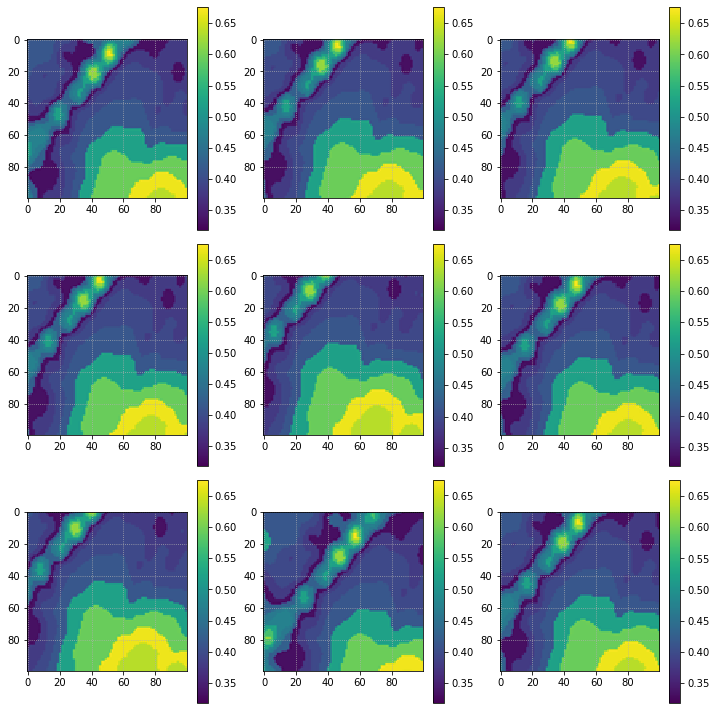

In [35]:
c = 10
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    plot = ax.imshow(augmented_tensor[i, ..., c])
    plt.colorbar(plot, ax=ax)
fig.tight_layout()

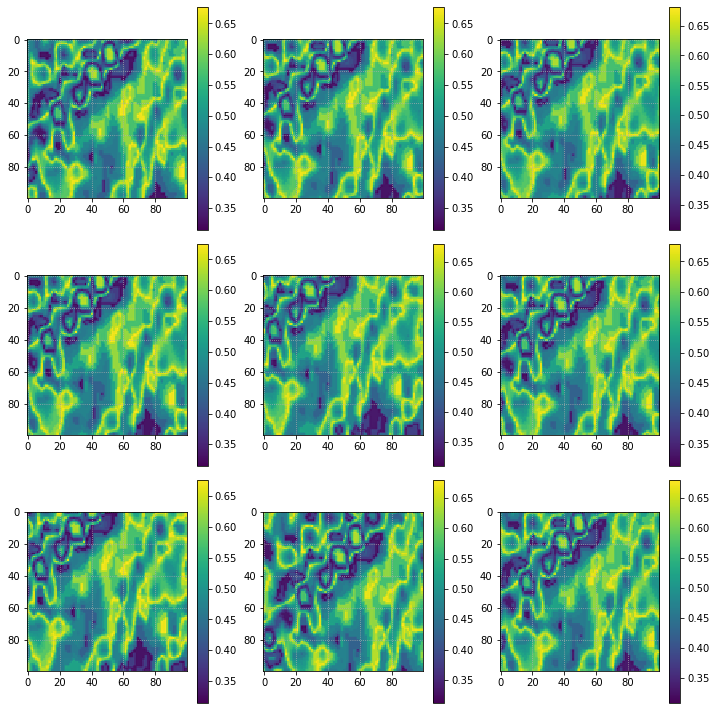

In [36]:
c = 11
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    plot = ax.imshow(augmented_tensor[i, ..., c])
    plt.colorbar(plot, ax=ax)
fig.tight_layout()

In [37]:
n_crops = 16 
px = 80 
seed = 217
augment_pos = random_crop(examples_pos, n_crops, px, seed)

In [41]:
examples_pos = np.concatenate((examples_pos, augment_pos), axis=0)
examples_pos.shape

(782, 100, 100, 45)

In [43]:
labels_pos = np.ones(len(examples_pos))
print(labels_pos.shape)

(782,)


In [39]:
augment_neg = random_crop(examples_neg, n_crops, px, seed)

In [42]:
examples_neg = np.concatenate((examples_neg, augment_neg), axis=0)
examples_neg.shape

(952, 100, 100, 45)

In [44]:
labels_neg = np.zeros(len(examples_neg))
print(labels_neg.shape)

(952,)


# Training and Test Set

In [45]:
train_examples = np.concatenate((examples_pos, examples_neg), axis=0)
print(train_examples.shape)

(1734, 100, 100, 45)


In [46]:
train_labels = np.concatenate((labels_pos, labels_neg), axis=0)
print(train_labels.shape)

(1734,)


In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    train_examples, train_labels, test_size=0.20, random_state=42
)
print(X_train.shape)
print(X_test.shape)

(1387, 100, 100, 45)
(347, 100, 100, 45)


In [48]:
def ND_scaler(tensor, train=True, feature_range=(0, 1), scalers=None):
    """
    batch min max scaler of tensors shaped (batch, ny, nx, nc)
    https://stackoverflow.com/questions/58646790/python-scaling-with-4d-data
    """
    return_scalers = {}
    transformed_tensor = np.zeros_like(tensor)
    nc = tensor.shape[-1]
    for i in range(nc):
        if train:
            scaler = MinMaxScaler(feature_range)
        else:
            scaler = scalers[i]
        row_vectors = tensor[..., i].reshape(
            tensor.shape[0], tensor.shape[1] * tensor.shape[2]
        )
        scaled = scaler.fit_transform(row_vectors)
        scaled = scaled.reshape(
            tensor.shape[0], tensor.shape[1], tensor.shape[2]
        )
        transformed_tensor[..., i] = scaled
        return_scalers[i] = scaler

    return [transformed_tensor, return_scalers] if train else transformed_tensor

In [49]:
X_train_scaled, scalers = ND_scaler(X_train)

In [50]:
X_test_scaled = ND_scaler(X_test, train=False, scalers=scalers)

In [51]:
X_train_scaled.shape

(1387, 100, 100, 45)

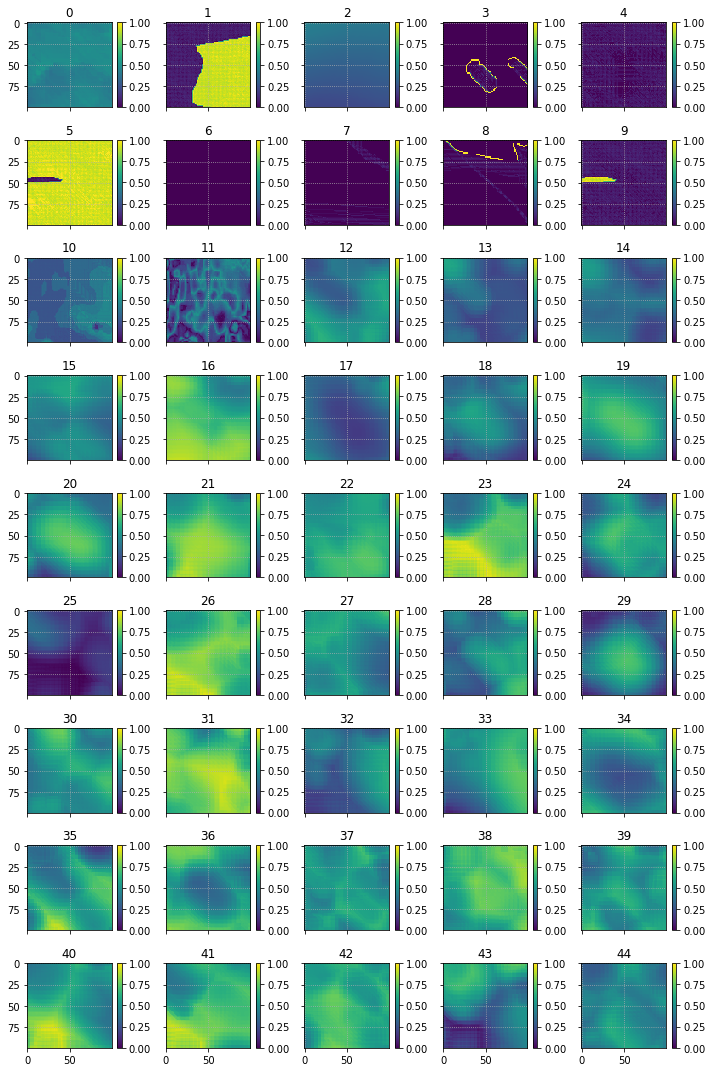

In [57]:
# fig, axes = plt.subplots(12, 10, figsize=(15, 15), sharex="all", sharey="all")
fig, axes = plt.subplots(9, 5, figsize=(10, 15), sharex="all", sharey="all")
axes = axes.flatten()
i = 0
for c, ax in enumerate(axes):
    im = ax.imshow(X_train_scaled[i, ..., c], vmin=0, vmax=1)
    ax.set_title(c)
    plt.colorbar(im, ax=ax)
fig.tight_layout()

In [63]:
X_train[i, ..., 1].min(), X_train[i, ..., 1].max()

(-34.61739730834961, 289.6174011230469)

In [64]:
X_train_scaled[i, ..., 1].min(), X_train_scaled[i, ..., 1].max()

(0.0, 1.0)

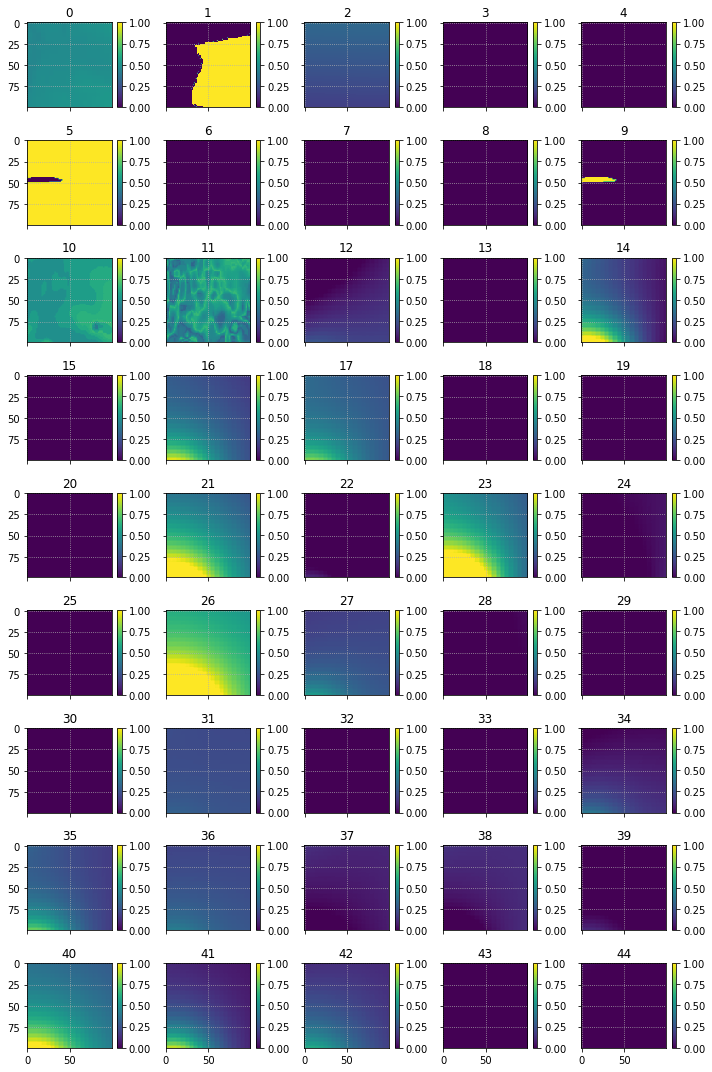

In [66]:
fig, axes = plt.subplots(9, 5, figsize=(10, 15), sharex="all", sharey="all")
axes = axes.flatten()
i = 0
for c, ax in enumerate(axes):
    im = ax.imshow(X_train[i, ..., c], vmin=0, vmax=1)
    ax.set_title(c)
    plt.colorbar(im, ax=ax)
fig.tight_layout()

In [53]:
to_pickle(
    "./outputs/train_test_set.pkl",
    [X_train_scaled, X_test_scaled, y_train, y_test],
)
to_pickle("./outputs/scalers.pkl", scalers)
to_pickle(
    "./outputs/prediction_tensor.pkl", pred_tensor,
)

In [54]:
# to_pickle(
#     "./outputs/train_test_set.pkl", [X_train, X_test, y_train, y_test],
# )
# to_pickle(
#     "./outputs/prediction_tensor.pkl", pred_tensor,
# )